In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import random, os
import numpy as np
import torch
import importlib
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE import vae, fg, bg
from objVAE import objVAE, MultiheadAttention


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

2023-10-24 14:12:01.619715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 14:12:03.214409: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

In [2]:
def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        #new_attention_row = attention_to_next_dt
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def run_test(testset, model, combine_radius, plot_num=0, num_entities=10, pres_floor=0.25, tra_floor=0.25):
    for i_seq, x in enumerate(testset):

        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        recon, indices, pres, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        recon = recon.detach().cpu().numpy()
        pres = pres.detach().cpu().numpy()
        xy = xy.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(xy.shape[0]):

            xp = xy[i, :, 0]
            yp = xy[i, :, 1]

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(20, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            pres_mask = pres[i] <= pres_floor

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0) + pres_mask

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(xy.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                    for ann in annotations:
                        ann.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                annotations = []
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    annotations.append(
                        plt.annotate(
                            round(pres[i, j], 3), (yp[j], xp[j]), color="white"
                        )
                    )
                plt.subplot(1, 2, 2)
                plt.imshow(recon[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )
            #new_attention = attention_to_next.detach().cpu().numpy()

            if i_seq == plot_num:
                print(new_attention)

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            binary_attention *= np.where(new_attention >= tra_floor, 1, 0)


            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.where(binary_attention == 1)
                #cols = np.argmax(binary_attention, axis=1)
                for i_col, _ in enumerate(cols[0]):
                    previous = cols[0][i_col]
                    current = cols[1][i_col]
                    if remove_map_v[i - 1][previous] or remove_map_v[i][current]:
                        continue
                    x_line = [xp_v[i - 1][previous], xp_v[i][current]]
                    y_line = [yp_v[i - 1][previous], yp_v[i][current]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")


def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        recon, indices, pres, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        alpha = pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(pres[0, alpha].detach().cpu().numpy())

    else:
        recon, indices, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

torch.Size([80, 5, 1, 256, 256])


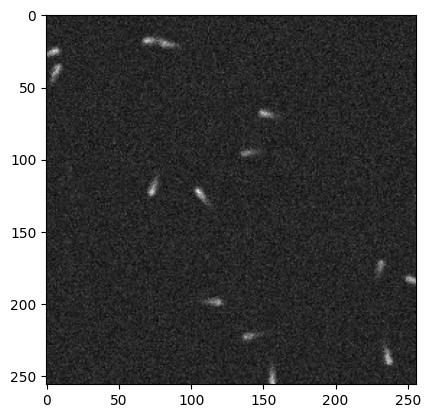

In [3]:
import tifffile
from glob import glob

x_crop = 256
y_crop = 256

paths = r'/data/mp_mpa/microtubule-sn7-low/*.tif'
paths = glob(paths)

images = [
    tifffile.imread(path) for path in paths
]
 
images = np.array(images)
images = np.array(np.split(images, 20, axis=0))

images_array = []
for i in range(images.shape[2] // x_crop):
    for j in range(images.shape[3] // y_crop):
        images_array.append(images[:, :, (i)*x_crop:(i+1)*x_crop, (j)*y_crop:(j+1)*y_crop])


images = np.concatenate(images_array, axis=0)

training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(1, 2, 3), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=2)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[8,0,:,:,:]), cmap='gray')


In [4]:
train, test = torch.utils.data.random_split(training_images, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(training_images, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=2, shuffle=False)

In [5]:
import IPython.display as ipd

# Callbacks
max_steps = 20000
beta_annealing_end = 1800
lr_annealing_end = max_steps
kl_annealing_end = 2400 # 2400
presence_annealing_end = 1000

def beta_annealing(step):
    logs = np.logspace(-4, -2.5, beta_annealing_end) # 8.3 - 7
    if step < beta_annealing_end:
        return logs[int(step)]
    else:
        return logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0
    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1

def presence_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 10:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [35]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

load_model = ""

#load_model = "../state_dicts/model-5-20000-presW-glim32-an.pth"
#load_model = "../state_dicts/model-microtubuler-256px-10.pth"


use_attention = True
num_entities = 25
softmax_tmp = 1
latent_dim = 5
beta = 1e-4
number_of_heads = 1
object_radius = 16
combine_method = "sum"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers=3
decoder_num_layers=4

single_decoder = True
attention_mechanism='cosine-similarity'
    

attention = MultiheadAttention.MultiheadAttention(
    max_t=1, attention_mechanism=attention_mechanism, softmax_factor=softmax_tmp, number_of_heads=1, num_filters=latent_dim-2
)
model = objVAE.MEVAE(
    num_entities,
    attention_model=attention,
    beta=beta,
    latent_dim=latent_dim,
    attention=use_attention,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


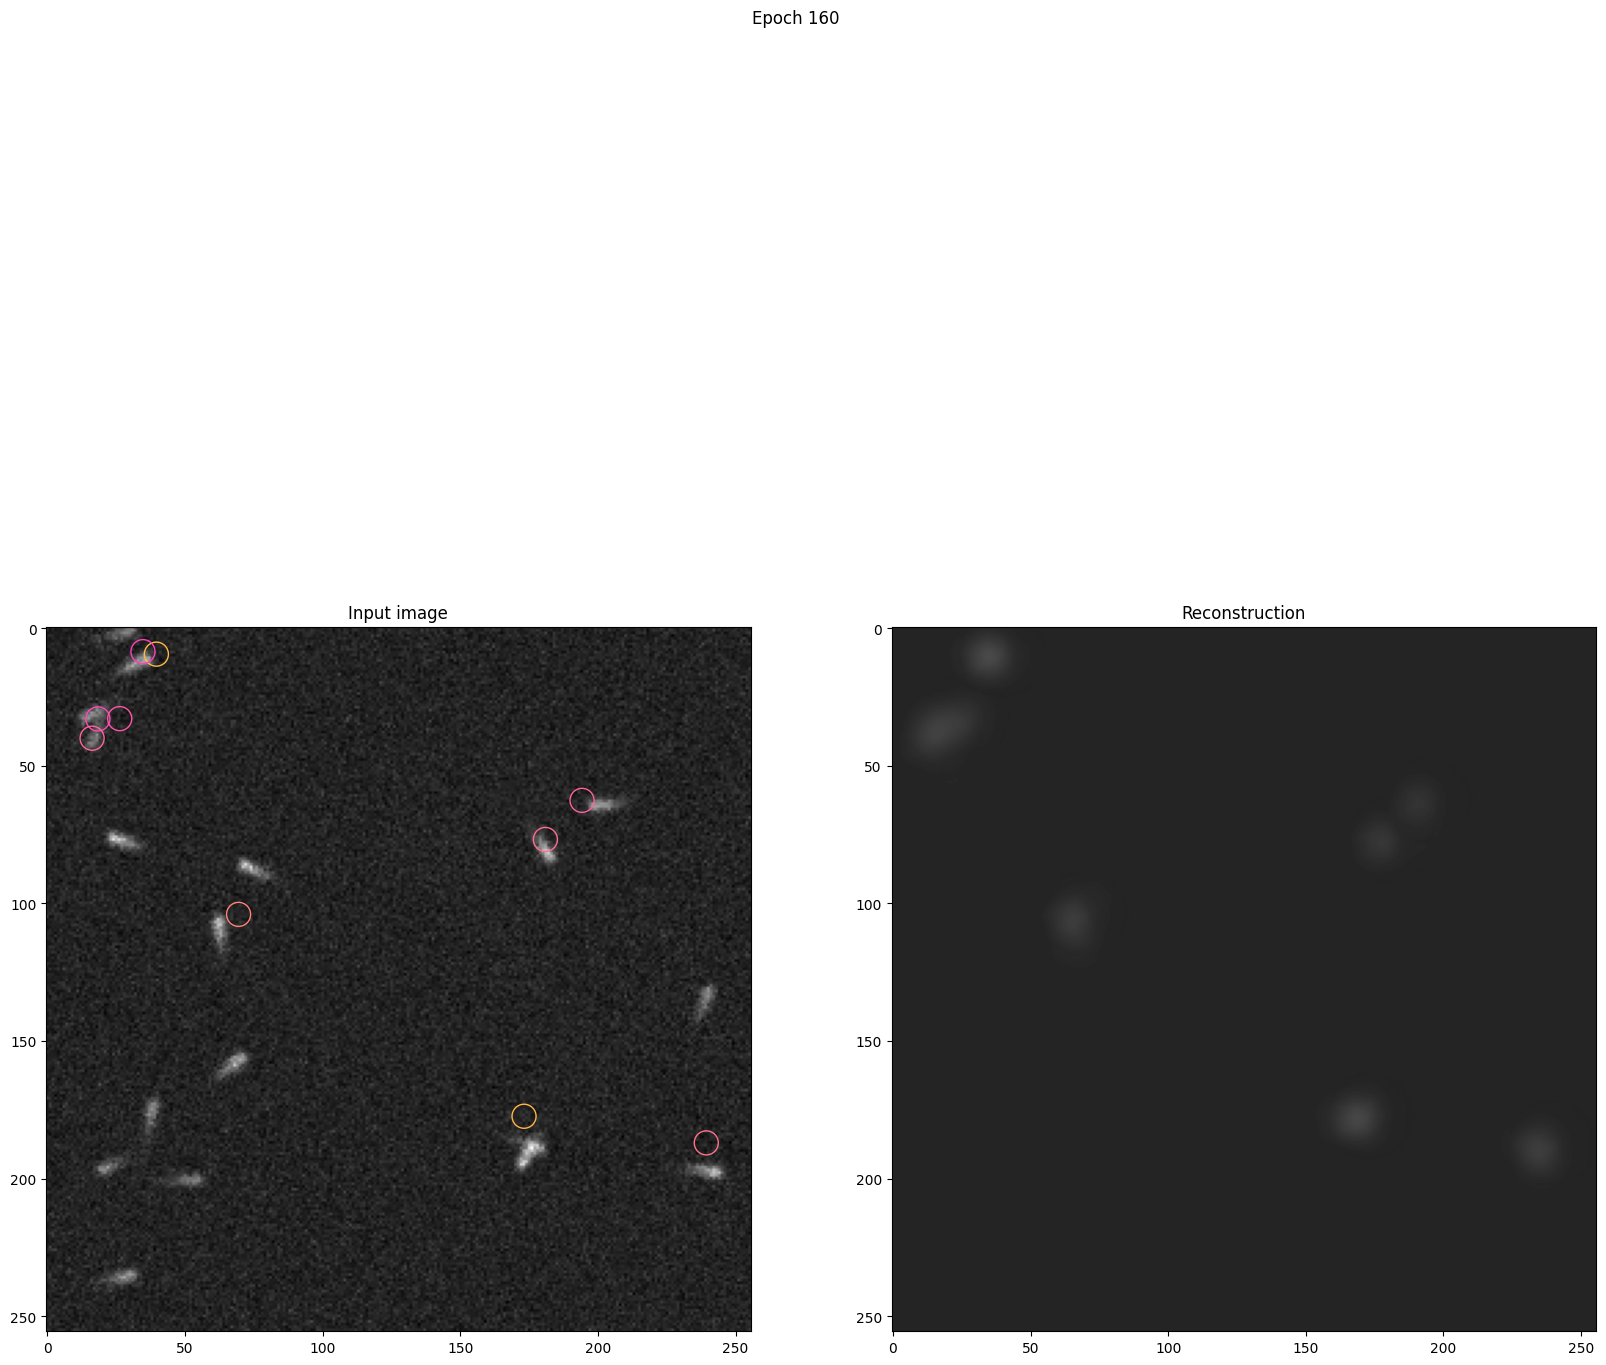

Epoch 162:  52%|█████▎    | 21/40 [00:00<00:00, 45.30it/s, v_num=1678, loss_step=0.108, reconstruction_loss_step=0.107, KLD_step=0.0196, weighted_KLD_step=6.2e-5, loss_epoch=0.108, reconstruction_loss_epoch=0.108, KLD_epoch=0.018, weighted_KLD_epoch=5.7e-5]   

In [36]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

...........
{'x': [11.811684], 'y': [28.315094], 'code': [-1], 'start': 0, 'end': 0}
{'x': [172.99266], 'y': [36.511963], 'code': [-1], 'start': 0, 'end': 0}
{'x': [234.70113], 'y': [27.202723], 'code': [-1], 'start': 0, 'end': 0}
{'x': [42.87556], 'y': [19.092983], 'code': [-1], 'start': 0, 'end': 0}
{'x': [4.6044297], 'y': [28.503246], 'code': [-1], 'start': 0, 'end': 0}
{'x': [12.220788], 'y': [37.659084], 'code': [-1], 'start': 0, 'end': 0}
{'x': [82.06763, 83.64947], 'y': [181.52187, 181.21637], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [90.21225, 84.51146], 'y': [76.21422, 68.7598], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [156.71684, 188.71716], 'y': [66.70037, 178.7467], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [36.574116, 36.642776], 'y': [18.979736, 12.76092], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [195.16394, 99.559814, 147.94756], 'y': [19.877579, 60.05289, 77.81354], 'code': [-1, -1, -1], 'start': 0, 'end': 2}
{'x': [203.5484, 237.22777, 235.65785], 'y

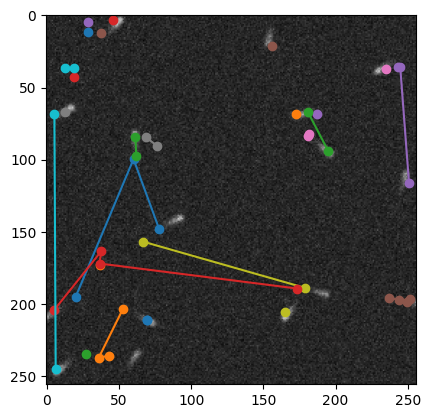

In [10]:
seq = test[0]

tra_list = model.extract_obj_and_tra(seq, 4, presence_floor=0.25, tra_floor=0.8)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

[[-3.22426617e-01  4.16836858e-01  5.58433294e-01  5.45410573e-01
   8.98005009e-01  2.72622049e-01  1.07380867e-01  2.45841011e-01
  -1.01535559e-01 -1.23036206e-02  8.18742216e-01  2.77978867e-01
   7.21163392e-01  5.61609030e-01  3.20152938e-03  0.00000000e+00
  -1.22249119e-01  2.33401656e-02  6.71392798e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.12796885e-01  3.90455425e-01  8.25403631e-02  5.80227971e-01
   6.56212687e-01 -9.24255848e-02  2.48127177e-01  3.50097030e-01
   4.89386916e-03  2.55276084e-01  1.42683417e-01  6.58484817e-01
   3.94691646e-01  7.64415741e-01  4.07357782e-01 -0.00000000e+00
   3.95820439e-01  7.93825030e-01  3.63245606e-02 -0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.82471085e-01  7.30149031e-01  1.88654006e-01  5.84128976e-01
   2.33922690e-01  5.94745159e-01  3.68727773e-01 -2.92449087e-01
   6.49341881e-01  2.14640796e-01  6.8

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

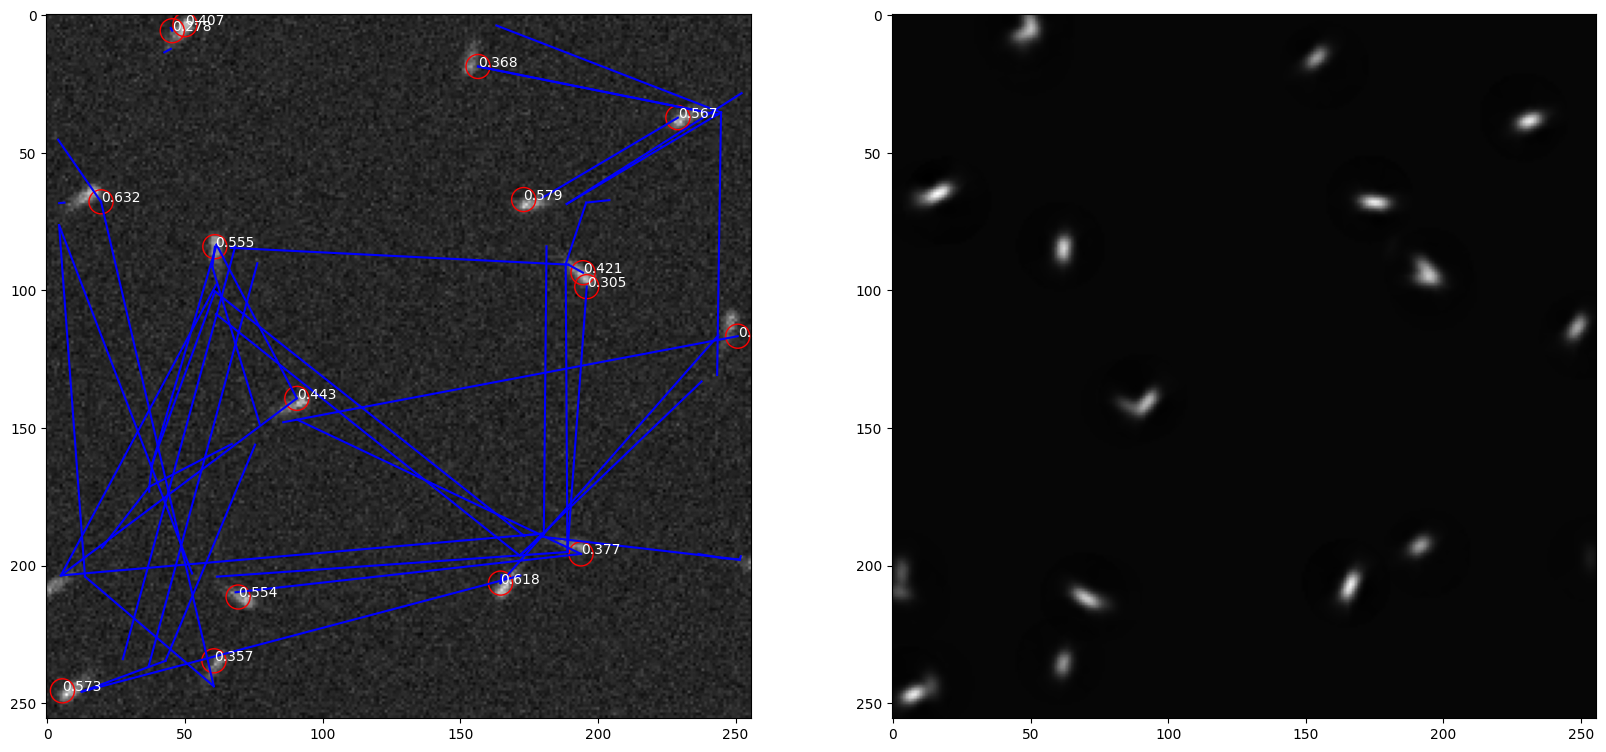

In [11]:
run_test(
    test,
    model,
    combine_radius=0.1,
    plot_num=0,
    num_entities=25,
    pres_floor=0.25,
    tra_floor=0.8
    )

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-microtubuler-256px-10.pth")